# 2) Training eines MLPs auf Spielzeugdaten

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(20)

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

<Figure size 720x540 with 0 Axes>

(200, 2)


Text(0.5, 1.0, 'Trainingset')

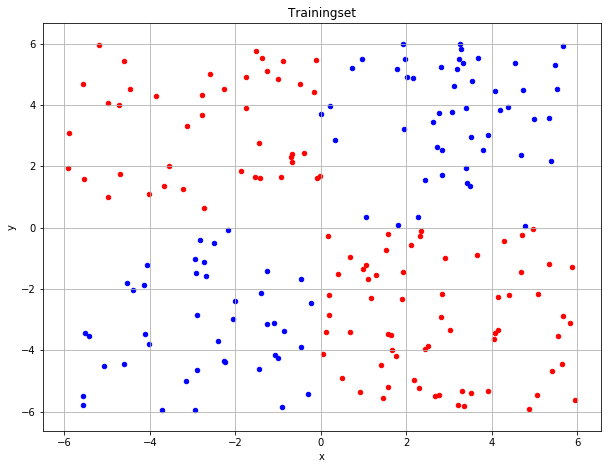

In [2]:
# Trainings-/Testpunkte erzeugen
def create_datapoints(n):
    x = np.asmatrix(np.random.uniform(-6, 6, n)).T
    y = np.asmatrix(np.random.uniform(-6, 6, n)).T
    return np.concatenate((x, y), axis=1)
    
x0 = create_datapoints(200)
x1 = create_datapoints(200)
x2 = create_datapoints(200)
print(x0.shape)

# Klassenlabels erzeugen
def determine_classes(matrix):
    classes = np.zeros((matrix.shape[0]))
    for i in range(matrix.shape[0]):
        if matrix[i, 0] * matrix[i, 1] >= 0:
            classes[i] = 1
        else:
            classes[i] = 0
    return classes

y0 = determine_classes(x0)
y1 = determine_classes(x1)
y2 = determine_classes(x2)

# plot dataset
train_data_df = pd.DataFrame(x0)

train_red_classes = pd.DataFrame(train_data_df[y0 == 0])
train_blue_classes = pd.DataFrame(train_data_df[y0 == 1])

train_ax1 = train_red_classes.plot.scatter(0, 1, color='r')
train_ax2 = train_blue_classes.plot.scatter(0, 1, color='b', ax=train_ax1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trainingset")

In [3]:
# scale the data
x0 = x0.astype('float64')
x1 = x1.astype('float64')
x2 = x2.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = y2.astype('float64')

Globale Arrays und Variablen des Netzwerkes:

In [4]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 0.2                    # Lernrate
no_hidden = 2                # Anzahl versteckter Neuronen
epochs = 1500                # Anzahl Epochen
sizes = [2, no_hidden, no_hidden, 1] # dreischichtiges MPL mit 2 Eingangs-, no_hidden versteckten, 1 Ausgangsneuronen
num_layers = len(sizes)      # Anzahl Schichten
activation_method = "SIGMOID"# Activation Method
cost_method = "MSE"

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[0].shape)

(2, 2)


Einige Hilfsfunktionen:

In [5]:
# Aktivierungsfunktion
def activation(z):
    if activation_method == "SIGMOID":
        return 1.0/(1.0+np.exp(-z))
    elif activation_method == "TANH":
        return np.tanh(z)

# Ableitung der Aktivierungsfunktion
def activation_prime(z):
    if activation_method == "SIGMOID":
        return activation(z)*(1-activation(z))
    elif activation_method == "TANH":
        return 1 - (np.tanh(z) * np.tanh(z))

# Kostenfunktion
def cost(ypred, y):
    if cost_method == "MSE":
        return (ypred - y)**2
    elif cost_method == "LOG":
        return -y * np.log(ypred) - ((1 - y) * np.log(1 - ypred))
    
# Ableitung der Kostenfunktion  
def cost_derivative(output_activations, y):
    if cost_method == "MSE":
        return (output_activations - y)
    elif cost_method == "LOG":
        return np.nan_to_num((-1*(output_activations - y)) / ((output_activations - 1) * output_activations))

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [6]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = activation(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [7]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation_value = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    
    for b, w in zip(biases, weights):
        z = np.asarray(np.dot(w, activation_value) + b)
        zs.append(z)
        activation_value = activation(z)
        activations.append(activation_value)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * activation_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = activation_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [8]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [9]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    cost_value = 0
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.asarray(x2[i]).T
        y = np.asarray(y2[i]).T
                
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        cpred = np.argmax(ypred)
        
        #calculate MSE
        cost_value += cost(ypred, y)
        
        # predict class
        threshold = 0.5
        if activation_method == "TANH":
            threshold = 0.0
            
        if ypred > threshold:
            cpred = 1
        else:
            cpred = 0
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if y == cpred:
            correct += 1
        
    return correct, cost_value

Stochastischer Gradientenabstieg:

In [10]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val_train = np.zeros(epochs)
    acc_val_test = np.zeros(epochs)
    cost_train = np.zeros(epochs)
    cost_test = np.zeros(epochs)

    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val_train[j], cost_train[j] = evaluate(x0, y0)
        acc_val_test[j], cost_test[j] = evaluate(x2, y2)
        if j % 100 == 0:
            print("Epoch {0}: Accuracy: {1} / {2} | {3} / {4} || Cost: {5} | {6}"\
                  .format(j, acc_val_train[j], n_test, acc_val_test[j], n_test, cost_train[j], cost_test[j]))
    
    return acc_val_train, acc_val_test, cost_train, cost_test

Training:

In [11]:
acc_val_train, acc_val_test, mse_train, mse_test = SGD(x0, y0, epochs, mbs, eta, x2, y2)

Epoch 0: Accuracy: 79.0 / 200 | 82.0 / 200 || Cost: 50.673981661445595 | 50.44642761393202
Epoch 100: Accuracy: 123.0 / 200 | 119.0 / 200 || Cost: 44.12989749447207 | 46.599358164276396
Epoch 200: Accuracy: 138.0 / 200 | 132.0 / 200 || Cost: 39.736510619909936 | 43.33124033994149
Epoch 300: Accuracy: 139.0 / 200 | 135.0 / 200 || Cost: 38.83775523929264 | 42.55995561869446
Epoch 400: Accuracy: 139.0 / 200 | 135.0 / 200 || Cost: 38.58373489645896 | 42.3844031831148
Epoch 500: Accuracy: 138.0 / 200 | 136.0 / 200 || Cost: 38.47298422985364 | 42.245429575462715
Epoch 600: Accuracy: 139.0 / 200 | 137.0 / 200 || Cost: 38.39724711877235 | 42.1929120190578
Epoch 700: Accuracy: 142.0 / 200 | 139.0 / 200 || Cost: 37.948959824600486 | 41.2618461331307
Epoch 800: Accuracy: 149.0 / 200 | 143.0 / 200 || Cost: 35.80802652874071 | 39.23588017139826
Epoch 900: Accuracy: 153.0 / 200 | 145.0 / 200 || Cost: 33.785808003914816 | 36.92271268073301
Epoch 1000: Accuracy: 154.0 / 200 | 148.0 / 200 || Cost: 31.3

Evaluation auf den unabhängigen Testdaten:

In [12]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Test accuracy: (198, matrix([[2.25619087]])) / 200


Lernkurve (Genauigkeit auf Validierungsdatensatz):

### 3) MSE und Accuracy

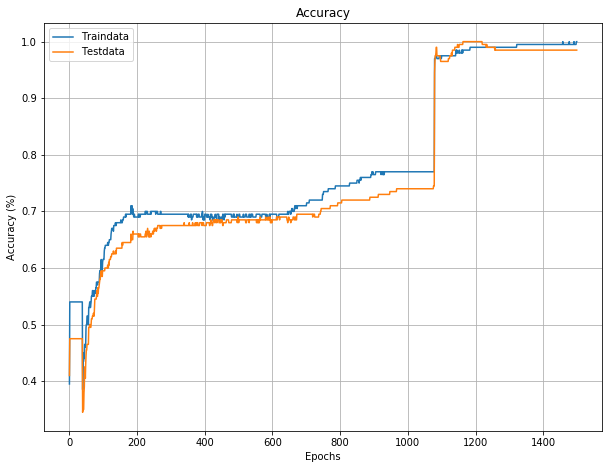

In [13]:
train, = plt.plot(acc_val_train/x0.shape[0], label="Traindata")
test, = plt.plot(acc_val_test/x2.shape[0], label="Testdata")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(handles=[train, test])

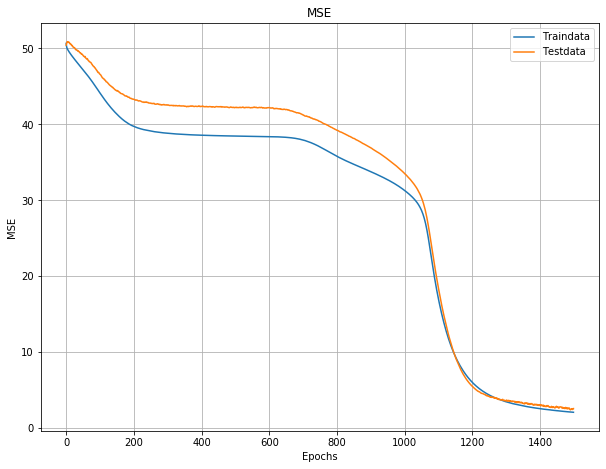

In [14]:
train, = plt.plot(mse_train, label="Traindata")
test, = plt.plot(mse_test, label="Testdata")
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(handles=[train, test])

### 4) Entscheidungsfunktion des 100x100-Gitters

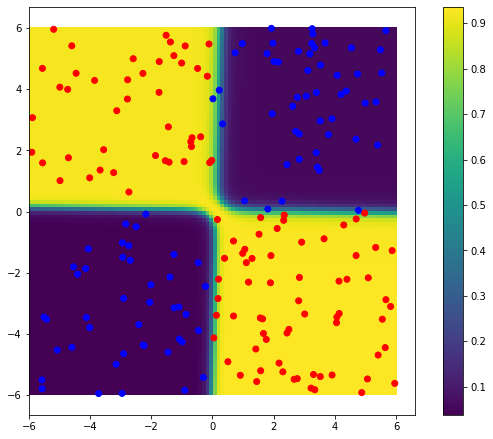

In [15]:
def get_grid(xmin, xmax, size):
    N = np.zeros((size, size))

    x = np.linspace(xmin, xmax, size)
    y = np.linspace(xmin, xmax, size)
    
    for xi in range(len(x)):
        for yi in range(len(y)):
            N[xi, yi] = feedforward([[x[xi]], [y[yi]]])
    
    return N

grid = get_grid(-6, 6, 100)
color = ['red' if element==0 else 'blue' for element in y0]

plt.grid()
im = plt.imshow(grid, extent=[-6, 6, -6, 6], cmap="viridis")
plt.scatter(np.asarray(x0[:, 0]), np.asarray(x0[:, 1]), color=color)
plt.colorbar(im)
plt.show()

# 3) Nachvollziehen der Beispiele aus der Vorlesung

In [16]:
np.random.seed(20)
activation_method = "TANH"

# Arrays für Gewichte und Schwellwerte neu initialisieren
biases = [np.random.randn(y, 1) for y in sizes[1:]]                      # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # Gewichte

acc_val_train, acc_val_test, mse_train, mse_test = SGD(x0, y0, epochs, mbs, eta, x2, y2)

Epoch 0: Accuracy: 92.0 / 200 | 105.0 / 200 || Cost: 91.69891634361669 | 78.08393095764512
Epoch 100: Accuracy: 172.0 / 200 | 167.0 / 200 || Cost: 2.4494110546845085 | 4.4193148264066116
Epoch 200: Accuracy: 182.0 / 200 | 182.0 / 200 || Cost: 1.4092773571897528 | 1.3110918359726935
Epoch 300: Accuracy: 129.0 / 200 | 143.0 / 200 || Cost: 1.0140720633698297 | 0.9042124202272865
Epoch 400: Accuracy: 149.0 / 200 | 148.0 / 200 || Cost: 1.1817501476241525 | 0.46430995821687976
Epoch 500: Accuracy: 187.0 / 200 | 189.0 / 200 || Cost: 1.325063270531303 | 0.6696793450422928
Epoch 600: Accuracy: 148.0 / 200 | 147.0 / 200 || Cost: 0.780808722588449 | 0.8601417950459066
Epoch 700: Accuracy: 149.0 / 200 | 146.0 / 200 || Cost: 1.1140886127846428 | 0.6445055309627324
Epoch 800: Accuracy: 188.0 / 200 | 193.0 / 200 || Cost: 0.8733922163566109 | 0.32801410899392197
Epoch 900: Accuracy: 131.0 / 200 | 151.0 / 200 || Cost: 0.8264786592794958 | 0.8201938688488077
Epoch 1000: Accuracy: 186.0 / 200 | 192.0 / 2

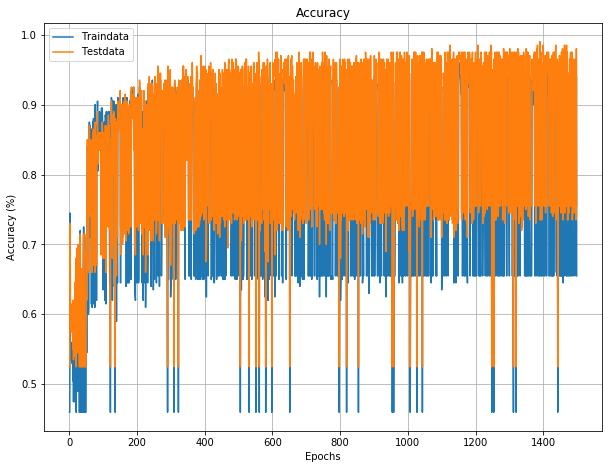

In [17]:
train, = plt.plot(acc_val_train/x0.shape[0], label="Traindata")
test, = plt.plot(acc_val_test/x2.shape[0], label="Testdata")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(handles=[train, test])

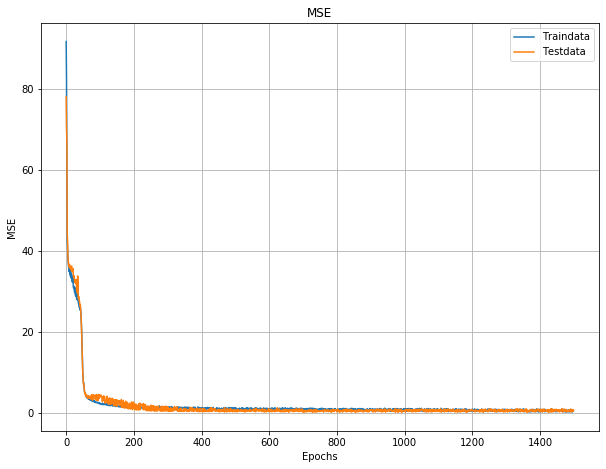

In [18]:
train, = plt.plot(mse_train, label="Traindata")
test, = plt.plot(mse_test, label="Testdata")
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(handles=[train, test])

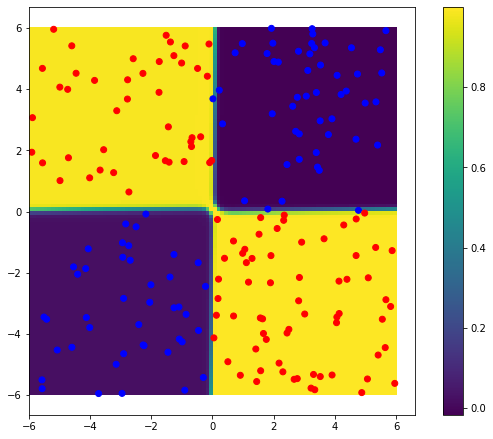

In [19]:
grid = get_grid(-6, 6, 100)
color = ['red' if element==0 else 'blue' for element in y0]

plt.grid()
im = plt.imshow(grid, extent=[-6, 6, -6, 6], cmap="viridis")
plt.scatter(np.asarray(x0[:, 0]), np.asarray(x0[:, 1]), color=color)
plt.colorbar(im)
plt.show()

# 4) Logistische Regression

In [20]:
np.random.seed(20)
activation_method = "SIGMOID"
cost_method = "LOG"
eta = 1.0

# Arrays für Gewichte und Schwellwerte neu initialisieren
biases = [np.random.randn(y, 1) for y in sizes[1:]]                      # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # Gewichte

acc_val_train, acc_val_test, cost_train, cost_test = SGD(x0, y0, epochs, mbs, eta, x2, y2)

[array([[ 0.55969629,  0.93946935],
       [-0.97848104,  0.50309684]]), array([[ 0.40641447,  0.32346101],
       [-0.49341088, -0.79201679]]), array([[-0.84236793, -1.27950266]])]
Epoch 0: Accuracy: 108.0 / 200 | 95.0 / 200 || Cost: 141.60228415459505 | 148.89921595513297
Epoch 100: Accuracy: 197.0 / 200 | 199.0 / 200 || Cost: 11.696281381511998 | 6.023297332208745
Epoch 200: Accuracy: 197.0 / 200 | 199.0 / 200 || Cost: 11.744993653595111 | 6.236782878821598
Epoch 300: Accuracy: 198.0 / 200 | 197.0 / 200 || Cost: 10.65973275408754 | 9.92046995498341
Epoch 400: Accuracy: 198.0 / 200 | 198.0 / 200 || Cost: 9.57334818184564 | 4.9580677323156275
Epoch 500: Accuracy: 197.0 / 200 | 199.0 / 200 || Cost: 10.104208017370828 | 4.161818567405658
Epoch 600: Accuracy: 198.0 / 200 | 199.0 / 200 || Cost: 5.6791685388367945 | 3.6044844283317774
Epoch 700: Accuracy: 197.0 / 200 | 199.0 / 200 || Cost: 7.726273470774665 | 5.878578991619333
Epoch 800: Accuracy: 198.0 / 200 | 199.0 / 200 || Cost: 7.00422

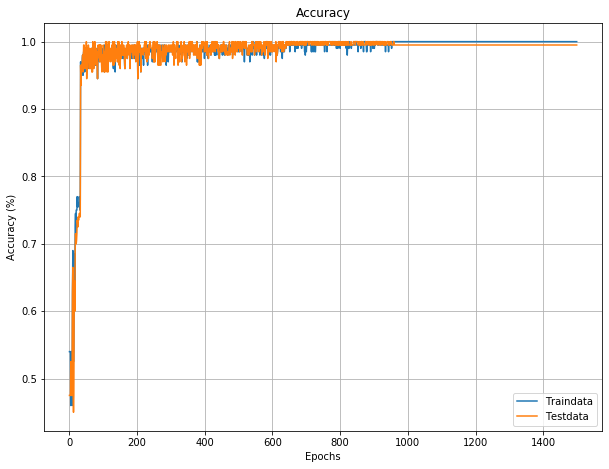

In [21]:
train, = plt.plot(acc_val_train/x0.shape[0], label="Traindata")
test, = plt.plot(acc_val_test/x2.shape[0], label="Testdata")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(handles=[train, test])

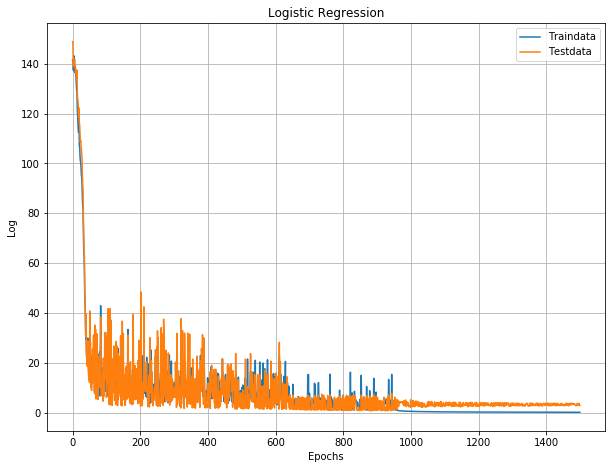

In [22]:
train, = plt.plot(cost_train, label="Traindata")
test, = plt.plot(cost_test, label="Testdata")
plt.title("Logistic Regression")
plt.xlabel("Epochs")
plt.ylabel("Log")
plt.legend(handles=[train, test])

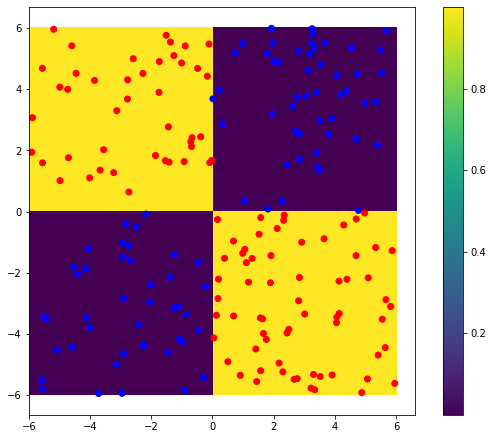

In [23]:
grid = get_grid(-6, 6, 100)
color = ['red' if element==0 else 'blue' for element in y0]

plt.grid()
im = plt.imshow(grid, extent=[-6, 6, -6, 6], cmap="viridis")
plt.scatter(np.asarray(x0[:, 0]), np.asarray(x0[:, 1]), color=color)
plt.colorbar(im)
plt.show()